# Face Area Calculations

Computing and working with face areas is important for the analysis of unstructured grids, with many algorithms and workflows requiring them. This section will showcase the different face area calculation options provided with UXarray:

1. Calculate Total Face Area
2. Quadrature and Order Options for `Grid.calculate_total_face_area` Function
3. Getting Area of Individual Faces
4. Calculate Area of a Single Triangle in Cartesian Coordinates
5. Calculate Area from Multiple Faces in Spherical Coordinates
6. Show Face Area Correction Formulae When an Edge is the Line of Constant Lattitude
7. Demonstrate the Need for Area Correction During Zonal Averaging Calculations Etc.

In [1]:
import uxarray as ux
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

We will be using the `outCSne30.ug` grid file, which is encoded in the UGRID convention.

In [2]:
base_path = "../../test/meshfiles/"
grid_path = base_path + "/ugrid/outCSne30/outCSne30.ug"

ugrid = ux.open_grid(grid_path)
ugrid

<uxarray.Grid>
Original Grid Type: UGRID
Grid Dimensions:
  * n_node: 5402
  * n_face: 5400
  * n_max_face_nodes: 4
Grid Coordinates (Spherical):
  * node_lon: (5402,)
  * node_lat: (5402,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
  * face_node_connectivity: (5400, 4)
Grid Descriptor Variables:

## 1. Calculate Total Face Area
We can calculate the total face area by calling the function `Grid.calculate_total_face_area()`. Since our dataset lies on the unit sphere, our expected area is $4 \pi$, which is approximately 12.56

In [3]:
t4_area = ugrid.calculate_total_face_area()
t4_area

np.float64(12.566370614678554)

## 2. Quadrature and Order Options for `Grid.calculate_total_face_area` Function

By default, `Grid.calculate_total_face_area` uses a Triangular Quadrature Rule and an Order of 4. However, you can specify the Quadrature Rule and Order as follows:


**Order:**

       1 to 10              for gaussian

       1, 4, 8, 10 and 12   for triangular


In [4]:
t1_area = ugrid.calculate_total_face_area(quadrature_rule="triangular", order=1)
t1_area

np.float64(12.571403993719983)

For the result above, notice that the area is slightly different than the first calculation we made.

Now we use Triangular Quadrature Rule and Order 1

Using a lower order is faster, but at the sacrifice of accuracy.

Generally, gaussian quadrature rule is more accurate than the triangular quadrature rule. Additionally, a higher order comes at the cost of computation time, but produces a more accurate result. See `uxarray/grid/area.py` file and function `get_gauss_quadratureDG` for details on quadrature points and weights.

## 3. Getting Area of Individual Faces

We can access the Grid attribute `Grid.face_area` to access the individual face areas. If you have not run a face area calculation yet, it will run the `Grid.compute_face_areas` and cache the value.



In [5]:
ugrid.face_areas

<xarray.DataArray 'face_areas' (n_face: 5400)> Size: 43kB
array([0.00211174, 0.00211221, 0.00210723, ..., 0.00210723, 0.00211221,
       0.00211174])
Dimensions without coordinates: n_face
Attributes:
    cf_role:    face_areas
    long_name:  Area of each face.

Now calculate the area again with the `Grid.compute_face_areas` function using arguments: quadrature_rule "gaussian" and order 4

In [6]:
all_face_areas, all_face_jacobians = ugrid.compute_face_areas(
    quadrature_rule="gaussian", order=4
)
g4_area = all_face_areas.sum()
g4_area

np.float64(12.566370614359112)

Now we compare the values with actual know value and report error for each of the three cases above.

In [7]:
actual_area = 4 * np.pi
diff_t4_area = np.abs(t4_area - actual_area)
diff_t1_area = np.abs(t1_area - actual_area)
diff_g4_area = np.abs(g4_area - actual_area)

diff_t1_area, diff_t4_area, diff_g4_area

(np.float64(0.005033379360810386),
 np.float64(3.1938185429680743e-10),
 np.float64(6.039613253960852e-14))

As we can see, it is clear that the Gaussian Quadrature Rule with Order 4 is the most accurate, and the Triangular Quadrature Rule with Order 1 is the least accurate.


## 4. Calculate Area of a Single Triangle in Cartesian Coordinates

For this section, we create a single triangle face with 3 vertices and plot it. By default, in `uxarray`, we assume that the coordinate system is spherical (lat / lon), however if you want to use cartesian coordinates, you must pass through `latlon = False` into the `Grid` constructor.

Assume the units in meters - this is a big triangle!

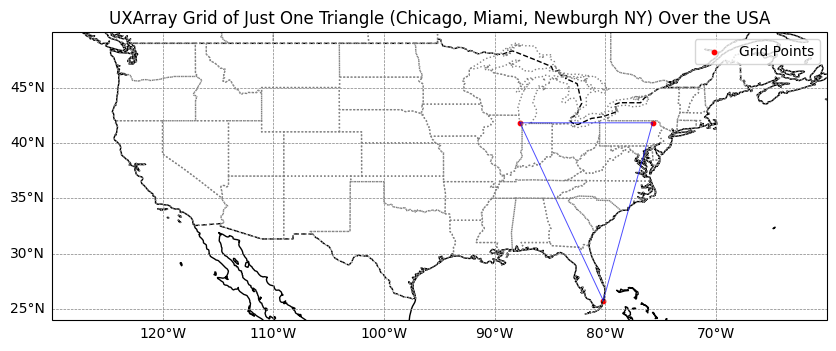

In [8]:
# Vertices
verts = [
    [0.02974582, -0.74469018, 0.66674712],
    [0.1534193, -0.88744577, 0.43462917],
    [0.18363692, -0.72230586, 0.66674712],
]

# Load vertices into a UXarray Grid object
vgrid = ux.open_grid(verts, latlon=False)

# Create figure with Cartopy projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the grid points (nodes)
ax.scatter(
    vgrid.node_lon,
    vgrid.node_lat,
    transform=ccrs.PlateCarree(),
    color="red",
    s=10,
    label="Grid Points",
)

# Add grid lines by connecting nodes using face-node connectivity
for face in vgrid.face_node_connectivity:
    face_nodes = face[face >= 0]  # Ignore invalid (-1) indices
    lons = vgrid.node_lon[face_nodes]
    lats = vgrid.node_lat[face_nodes]
    # Close the loop by adding the first point at the end
    lons = np.append(lons, lons[0])
    lats = np.append(lats, lats[0])
    ax.plot(
        lons, lats, transform=ccrs.PlateCarree(), color="blue", linewidth=0.7, alpha=0.7
    )

# Set extent to show only the USA
ax.set_extent([-130, -60, 24, 50], crs=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black")  # Country borders
ax.add_feature(cfeature.COASTLINE, edgecolor="black")  # Coastlines
ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="gray")  # US State boundaries

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.right_labels = False
gl.top_labels = False

plt.title(
    "UXArray Grid of Just One Triangle (Chicago, Miami, Newburgh NY) Over the USA"
)
plt.legend()
plt.show()

Now compute the area of the above triangle with and without correction and compare, also use higher quadrature

In [ ]:
area = vgrid.calculate_total_face_area()
corrected_area = vgrid.calculate_total_face_area(latitude_adjusted_area=True)
percentage_correction = (corrected_area - area) / corrected_area * 100
print(
    f"Percentage correction due to line of constant latitude being one of the edges: {percentage_correction:.4f}%"
)

Percentage correction due to line of constant latitude being one of the edges: 1.2576%


In [10]:
# Calculate the area of the triangle with lower gaussian quadrature order
area_gaussian = vgrid.calculate_total_face_area(quadrature_rule="gaussian", order=2)
print("Area calculated using Gaussian Quadrature Order 2: ", area_gaussian)

print(
    "Percentage difference between gaussian area above and corrected area: {:.4f}%".format(
        (corrected_area - area_gaussian) / corrected_area * 100
    )
)

Area calculated using Gaussian Quadrature Order 2:  0.022165612979675488
Percentage difference between gaussian area above and corrected area: 1.2599%


## 5. Calculate Area from Multiple Faces in Spherical Coordinates

Similar to above, we can construct a `Grid` object with multiple faces by passing through a set of vertices. Here we define 3 six-sided faces.

In [11]:
faces_verts_ndarray = np.array(
    [
        np.array(
            [
                [150, 10, 0],
                [160, 20, 0],
                [150, 30, 0],
                [135, 30, 0],
                [125, 20, 0],
                [135, 10, 0],
            ]
        ),
        np.array(
            [
                [125, 20, 0],
                [135, 30, 0],
                [125, 60, 0],
                [110, 60, 0],
                [100, 30, 0],
                [105, 20, 0],
            ]
        ),
        np.array(
            [
                [95, 10, 0],
                [105, 20, 0],
                [100, 30, 0],
                [85, 30, 0],
                [75, 20, 0],
                [85, 10, 0],
            ]
        ),
    ]
)

We want our units to be spherical, so we pass through `latlon=True`. Additionally, if `latlon` is not passed through, it will default to spherical coordinates.

In [12]:
verts_grid = ux.open_grid(faces_verts_ndarray, latlon=True)

verts_grid
verts_grid.plot()

:Path   [Longitude,Latitude]

In [ ]:
area, _ = verts_grid.compute_face_areas()
print("Area:", area)
corrected_area, _ = verts_grid.compute_face_areas(latitude_adjusted_area=True)
print("Corrected Area:", corrected_area)

total_percentage_difference = ((corrected_area - area) / area) * 100
print("Total Percentage Difference:", total_percentage_difference)

Area: [0.14323746 0.25118746 0.12141312]
Corrected Area: [0.14354712 0.25042962 0.12190143]
Total Percentage Difference: [ 0.2161859  -0.30170321  0.40218883]


## 6. Area Correction

The correction, \(A\), is calculated using the following formula:

$A = 2 \arctan\left(\frac{z(x_1 y_2 - x_2 y_1)}{x_1^2 + y_1^2 + x_1 x_2 + y_1 y_2} - \frac{z (x_1 y_2 - x_2 y_1)}{x_1 x_2 + y_1 y_2}\right)$

### Where:
<ul>

<li>(x<sub>1</sub>, y<sub>1</sub>, z) are the Cartesian coordinates of the first node.</li>

<li>(x<sub>2</sub>, y<sub>2</sub>, z) are the Cartesian coordinates of the second node (note that the z coordinate is the same for both nodes).</li>

</ul>

### Assumptions:
- This formula assumes that the input coordinates $(x_1, y_1)$ and $(x_2, y_2)$ are normalized (i.e., they lie on the unit sphere).


### The following code:
- Creates a BIG spherical rectangle and calculates the exact area using the spherical excess formula.
- Plots the rectangle, it has two lines of constant lattitude.
- A mesh is formed with uxarray and area is calculated
- Area is again calculated with `latitude_adjusted_area` flag set to `True`

In [14]:
def theoretical_spherical_rectangle_area(lons, lats, radius=1):
    """
    Calculate the area of a spherical rectangle on a sphere.

    Parameters:
        lons (np.ndarray): Longitudes of the rectangle's corners (in degrees).
        lats (np.ndarray): Latitudes of the rectangle's corners (in degrees).
        radius (float): Radius of the sphere (default is unit sphere).

    Returns:
        float: Area of the spherical rectangle in steradians (or square units if radius is provided).
    """
    # Convert degrees to radians
    lons_rad = np.radians(lons)
    lats_rad = np.radians(lats)

    # Compute longitude and latitude differences
    delta_lambda = abs(lons_rad[0] - lons_rad[2])  # Assuming rectangular shape
    sin_phi_diff = abs(np.sin(lats_rad[0]) - np.sin(lats_rad[2]))

    # Calculate area
    area = radius**2 * delta_lambda * sin_phi_diff
    return area


# Define nodes
node_lon = np.array([90.0, 90.0, 10.0, 10.0])  # Longitudes in degrees
node_lat = np.array([80.0, 10.0, 10.0, 80.0])  # Latitudes in degrees

# Calculate the area
area_steradians = theoretical_spherical_rectangle_area(node_lon, node_lat)
print(
    f"The area of the spherical rectangle is approximately {area_steradians:.6f} steradians"
)

# If Earth's radius is used (R ≈ 6371 km):
earth_radius_km = 6371
area_km2 = theoretical_spherical_rectangle_area(
    node_lon, node_lat, radius=earth_radius_km
)
print(
    f"The area of the spherical rectangle is approximately {area_km2:.2f} square kilometers"
)

The area of the spherical rectangle is approximately 1.132592 steradians
The area of the spherical rectangle is approximately 45971520.05 square kilometers


In [15]:
# Define face-node connectivity and create/plot a uxarray object face
face_node_connectivity = np.array([[0, 1, 2, 3]])

face = ux.Grid.from_topology(
    node_lon=node_lon,
    node_lat=node_lat,
    face_node_connectivity=face_node_connectivity,
    fill_value=-1,
)
face.plot(backend="bokeh")

:Path   [Longitude,Latitude]

In [16]:
area_no_correction = face.compute_face_areas(quadrature_rule="gaussian", order=8)

In [ ]:
corrected_area = face.compute_face_areas(
    quadrature_rule="gaussian", order=8, latitude_adjusted_area=True
)

In [18]:
# Calculate the percentage difference between the corrected and uncorrected areas
percentage_difference = (
    (corrected_area[0][0] - area_no_correction[0][0]) / area_no_correction[0][0] * 100
)

print(
    f"The percentage difference between the corrected and uncorrected areas is {percentage_difference:.2f}%"
)

The percentage difference between the corrected and uncorrected areas is 3.73%


# 7. Demonstrate the Need for Area Correction During Zonal Averaging Calculations Etc.

When performing zonal averaging, it is common practice to calculate the intersection of faces with lines of constant latitude and longitude. 

However, this approach can introduce small errors if the correct area adjustments are not applied. 

Below is a demonstration of the impact of such errors:

In [ ]:
# Define the latitude and longitude points
lon1, lon2, lon3, lon4 = -97.5, -87.5, -82.5, -92.5
lat1, lat2, lat3, lat4 = 32.0, 31.0, 35.0, 36.0

# Define the rectangle center and midlines
rect_center_lon = -90
rect_center_lat = 34

# Define intersection points computed with rect_center defined above
int_14 = (-95.0, 34.0)
int_23 = (-83.75, 34.0)
int_12 = (-90.0, 31.25)
int_34 = (-90.0, 35.75)

# Define nodes for polygons
node_lon = np.array(
    [
        int_14[0],
        rect_center_lon,
        int_12[0],
        lon1,  # Polygon 1
        int_12[0],
        rect_center_lon,
        int_23[0],
        lon2,  # Polygon 2
        int_23[0],
        rect_center_lon,
        int_34[0],
        lon3,  # Polygon 3
        int_34[0],
        rect_center_lon,
        int_14[0],
        lon4,  # Polygon 4
    ]
)

node_lat = np.array(
    [
        int_14[1],
        rect_center_lat,
        int_12[1],
        lat1,  # Polygon 1
        int_12[1],
        rect_center_lat,
        int_23[1],
        lat2,  # Polygon 2
        int_23[1],
        rect_center_lat,
        int_34[1],
        lat3,  # Polygon 3
        int_34[1],
        rect_center_lat,
        int_14[1],
        lat4,  # Polygon 4
    ]
)

# Define face-node connectivity (each polygon is a separate face)
face_node_connectivity = np.array(
    [
        [0, 1, 2, 3],  # Polygon 1
        [4, 5, 6, 7],  # Polygon 2
        [8, 9, 10, 11],  # Polygon 3
        [12, 13, 14, 15],  # Polygon 4
    ]
)

# Create UXArray grid for four small polygons
faces = ux.Grid.from_topology(
    node_lon=node_lon,
    node_lat=node_lat,
    face_node_connectivity=face_node_connectivity,
    fill_value=-1,
)

# Compute the area of each polygon
small_areas = faces.compute_face_areas(quadrature_rule="gaussian", order=4)
corrected_small_areas = faces.compute_face_areas(
    quadrature_rule="gaussian", order=4, latitude_adjusted_area=True
)
faces.plot(
    backend="bokeh", title="Four Polygons With One Edge on a Line of Constant Latitude"
)

:Path   [Longitude,Latitude]

This table demonstrates that when intersections with lines of constant latitude and longitude are performed, small discrepancies in area calculation can occur. While these errors may seem minor for individual polygons, they can accumulate over a larger dataset, leading to noticeable inaccuracies in zonal averaging. Applying a correction ensures the computed areas remain consistent and accurate. It must be noted that the correction is positive for some faces and negative for others causing the total sum to remain the same.
| Polygon | Original Area | Corrected Area | Percentage Difference |
|---------|--------------|---------------|----------------------|
| Polygon 1 | 0.00387988 | 0.00385858 | -0.5488% |
| Polygon 2 | 0.00329592 | 0.00325432 | -1.2621% |
| Polygon 3 | 0.00245684 | 0.00249844 | 1.6932% |
| Polygon 4 | 0.00178601 | 0.00180730 | 1.1922% |

### Total Area Comparison

| Total Area (4 Polygons) | Corrected Total Area | Percentage Difference |
|-------------------------|---------------------|----------------------|
| 0.01141865 | 0.01141865 | 0.0000% |

In [ ]:
# Print area of all 4 faces:
print("Area of each polygon:")
for i, area in enumerate(small_areas[0]):
    print(
        f"Polygon {i + 1}: {area:.8f}, Corrected Area: {corrected_small_areas[0][i]:.8f}, Percentage Difference: {(corrected_small_areas[0][i] - area) / area * 100:.4f}%"
    )

# Print the sum of areas of 4 faces is same for corrected and uncorrected areas
print(
    f"Total area of 4 polygons: {small_areas[0].sum():.8f}, Corrected total area of 4 polygons: {corrected_small_areas[0].sum():.8f}, Percentage Diff: {(corrected_small_areas[0].sum() - small_areas[0].sum()) / small_areas[0].sum() * 100:.4f}%"
)

Area of each polygon:
Polygon 1: 0.00387988, Corrected Area: 0.00385858, Percentage Difference: -0.5488%
Polygon 2: 0.00329592, Corrected Area: 0.00325432, Percentage Difference: -1.2621%
Polygon 3: 0.00245684, Corrected Area: 0.00249844, Percentage Difference: 1.6932%
Polygon 4: 0.00178601, Corrected Area: 0.00180730, Percentage Difference: 1.1922%
Total area of 4 polygons: 0.01141865, Corrected total area of 4 polygons: 0.01141865, Percentage Diff: 0.0000%


In the code snippet below, we compute the area of larger faces that do not contain edges along lines of constant latitude and compare it with the sum of the areas calculated above. This comparison demonstrates the necessity of applying area corrections when a face includes an edge that follows a line of constant latitude. Without such corrections, errors in area estimation may arise, potentially impacting calculations that rely on precise spatial measurements.

In [28]:
large_node_lon = np.array([lon1, lon2, lon3, lon4])
large_node_lat = np.array([lat1, lat2, lat3, lat4])
large_face_node_connectivity = np.array([[0, 1, 2, 3]])

large_face = ux.Grid.from_topology(
    node_lon=large_node_lon,
    node_lat=large_node_lat,
    face_node_connectivity=large_face_node_connectivity,
    fill_value=-1,
)

large_area = large_face.compute_face_areas(quadrature_rule="gaussian", order=4)
large_face.plot()
print(f"Area of the face is: {large_area[0][0]:.8f}")
large_face.plot(
    backend="bokeh",
    title="Large Face With No Edges on a Line of Constant Latitude (No Area Correction)",
)

Area of the face is: 0.01143206


:Path   [Longitude,Latitude]

In [30]:
percentage_diff = (large_area[0][0] - small_areas[0].sum()) / large_area[0][0] * 100
print(
    f"Percentage difference between large face and sum of small faces: {percentage_diff:.4f}%"
)

Percentage difference between large face and sum of small faces: 0.1173%
